# HMM for Regime Detection
Metrics to consider: RSI, Fear and Greed Index, Returns, high/low price Range, % change of price Range, Garch(1,1)
Checking for standard scaler and robust scaler
Checking for Gaussian HMM and GMMHMM
Evaluating for all compinations, via plotting and silhouette scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import itertools
from matplotlib.lines import Line2D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
ticker = 'BTC-USD'
start = '2018-02-01'
end = '2025-03-10'
raw_data = yf.download(ticker, start, end)
data = raw_data[['Close', 'High', 'Low']]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low
Ticker,BTC-USD,BTC-USD,BTC-USD
Date,,,
2018-02-01,9170.540039,10288.799805,8812.280273
2018-02-02,8830.750000,9142.280273,7796.490234
2018-02-03,9174.910156,9430.750000,8251.629883
2018-02-04,8277.009766,9334.870117,8031.220215
2018-02-05,6955.270020,8364.839844,6756.680176


In [3]:
import requests

r = requests.get('https://api.alternative.me/fng/?limit=0&&date_format=cn') #cn for (YYYY/MM/DD)

fg = pd.DataFrame(r.json()['data'])

fg["timestamp"] = pd.to_datetime(fg["timestamp"])  
fg.set_index("timestamp", inplace=True)

fg

,value,value_classification,time_until_update
timestamp,,,
2025-03-20,49,Neutral,-1742402771
2025-03-19,32,Fear,NaN
2025-03-18,34,Fear,NaN
2025-03-17,32,Fear,NaN
2025-03-16,30,Fear,NaN
...,...,...,...
2018-02-05,11,Extreme Fear,NaN
2018-02-04,24,Extreme Fear,NaN
2018-02-03,40,Fear,NaN


In [4]:
df = data.copy()

# Returns and Range(Volatility)
df["Returns"] = np.log(df["Close"] / df["Close"].shift(1))
df["Range"] = (df["High"] / df["Low"]) - 1
df["Log_Range"] = (np.log(df["High"] / df["Low"]))
df["pct_Range"] = df["Range"] / df["Range"].shift(1) -1

# Fear and Greed Index
fg["value"] = pd.to_numeric(fg["value"], errors="coerce") 

df["fg"] = fg["value"].reindex(df.index)
df["pct_fg"] = df["fg"] / df["fg"].shift(1) -1

# RSI index
import pandas_ta as ta
df["RSI"] = ta.rsi(df["Close"]["BTC-USD"], length=14)
df["pct_RSI"] = df["RSI"] / df["RSI"].shift(1) -1

df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Returns,Range,Log_Range,pct_Range,fg,pct_fg,RSI,pct_RSI
Ticker,BTC-USD,BTC-USD,BTC-USD,,,,,,,,
Date,,,,,,,,,,,
2018-02-16,10233.900391,10324.099609,9824.820312,0.006618,0.050818,0.049569,-0.431059,67.0,-0.056338,63.799058,0.007788
2018-02-17,11112.700195,11139.500000,10149.400391,0.082383,0.097553,0.093083,0.919639,74.0,0.104478,69.537696,0.089949
2018-02-18,10551.799805,11349.799805,10326.000000,-0.051792,0.099148,0.094535,0.016353,63.0,-0.148649,62.705291,-0.098255
2018-02-19,11225.299805,11273.799805,10513.200195,0.061874,0.072347,0.069850,-0.270310,67.0,0.063492,66.909576,0.067048
2018-02-20,11403.700195,11958.500000,11231.799805,0.015768,0.064700,0.062693,-0.105697,74.0,0.104478,67.940541,0.015408


In [5]:
print(min(df["pct_Range"]))
print(max(df["pct_Range"]))

-0.9228609279398111
16.99709003255204


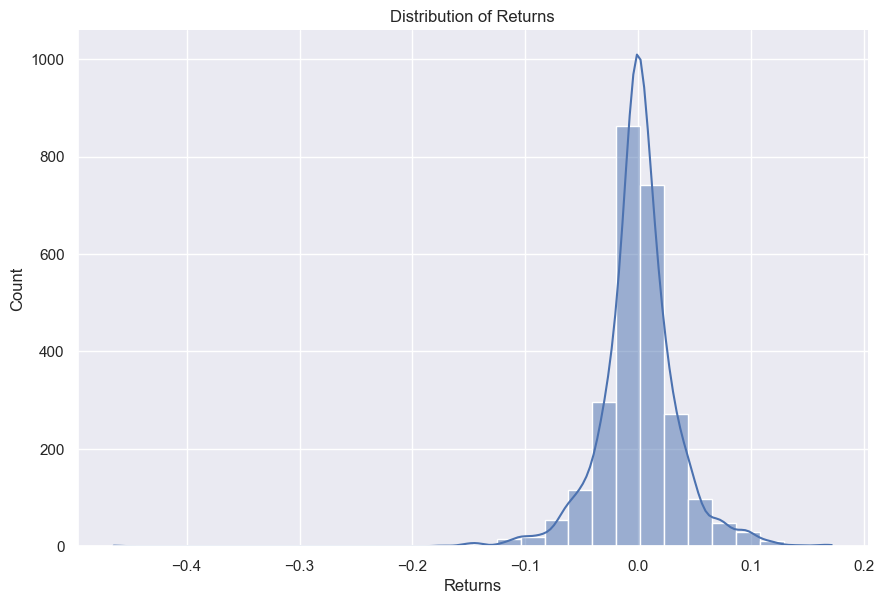

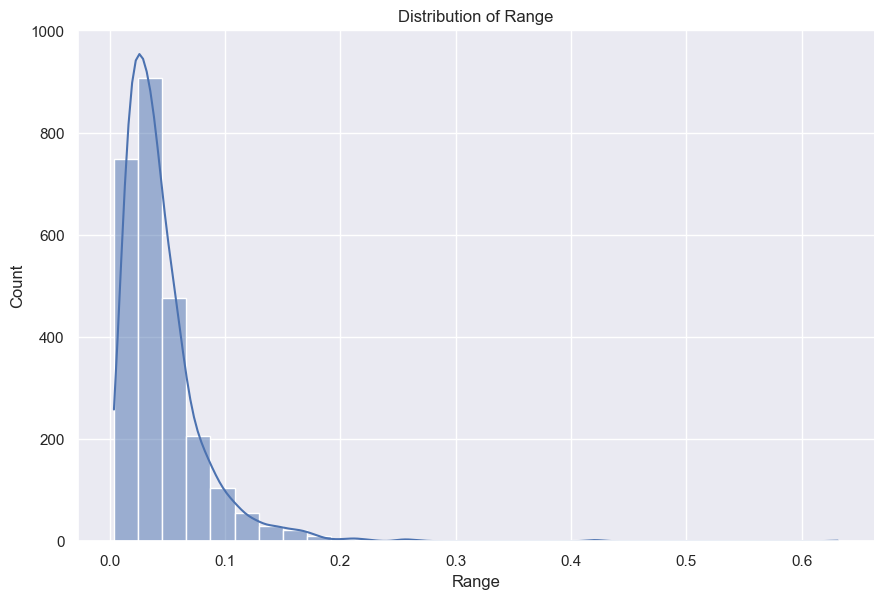

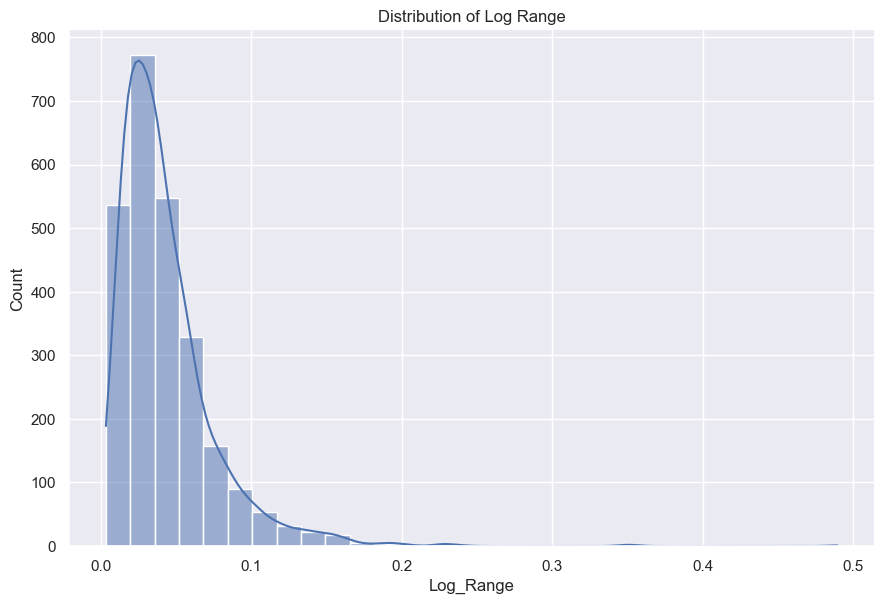

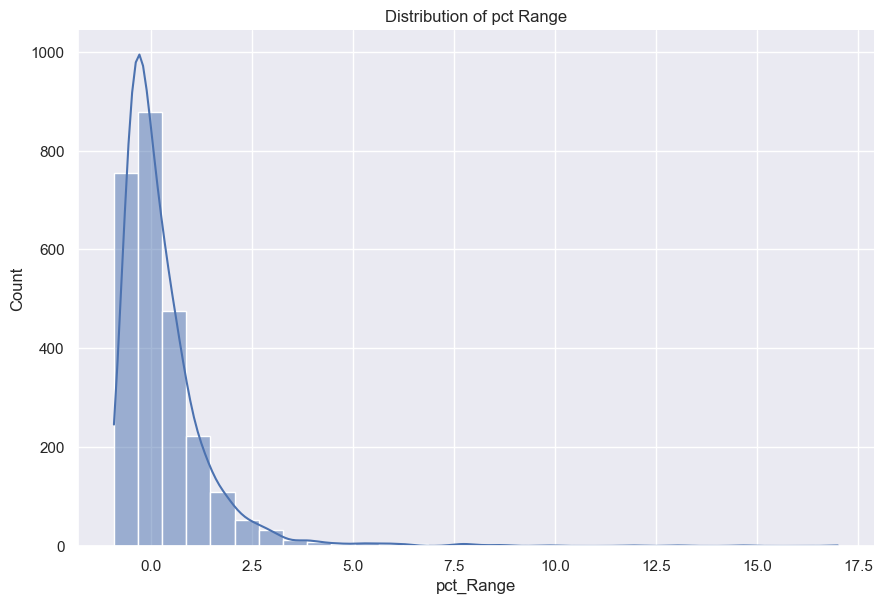

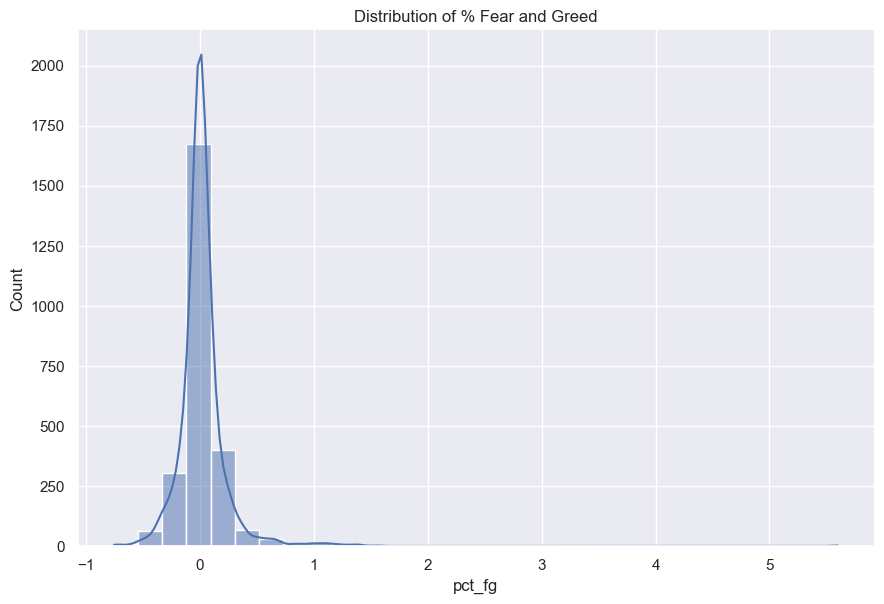

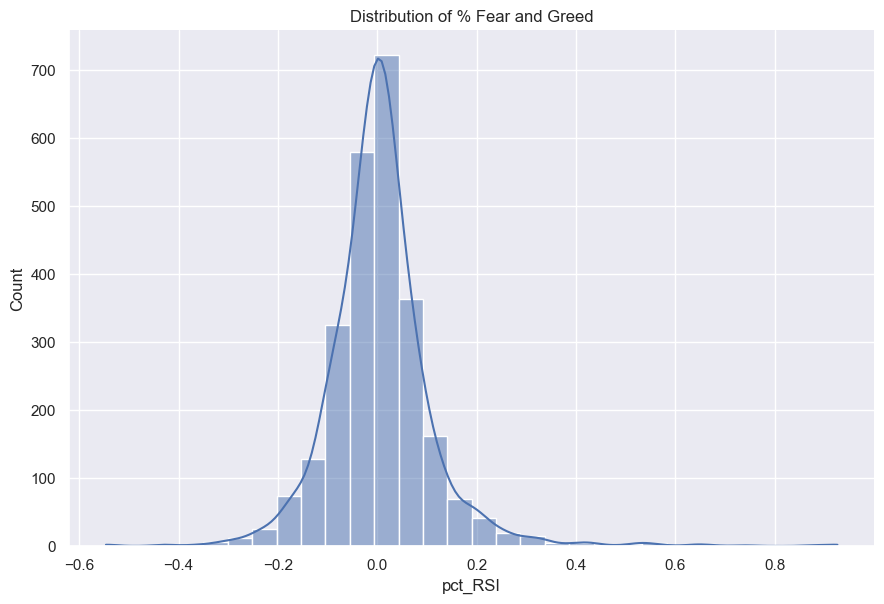

In [6]:
# Plot for Returns using displot
sns.displot(df["Returns"], kind="hist", bins=30, kde=True, height=6, aspect=1.5)
plt.title("Distribution of Returns")
plt.show()

sns.displot(df["Range"], kind="hist", bins=30, kde=True, height=6, aspect=1.5) 
plt.title("Distribution of Range")
plt.show()

sns.displot(df["Log_Range"], kind="hist", bins=30, kde=True, height=6, aspect=1.5)
plt.title("Distribution of Log Range")
plt.show()

sns.displot(df["pct_Range"], kind="hist", bins=30, kde=True, height=6, aspect=1.5)
plt.title("Distribution of pct Range")
plt.show()

sns.displot(df["pct_fg"], kind="hist", bins=30, kde=True, height=6, aspect=1.5)
plt.title("Distribution of % Fear and Greed")
plt.show()

sns.displot(df["pct_RSI"], kind="hist", bins=30, kde=True, height=6, aspect=1.5)
plt.title("Distribution of % Fear and Greed")
plt.show()

In [7]:
size = int(len(df) * 0.8)
col_list = ["Returns", "Range", "Log_Range", "pct_Range", "fg", "pct_fg", "RSI", "pct_RSI"]
X_train = df[col_list].iloc[:size,:]
X_test = df[col_list].iloc[size:,:]
X_train.head()

Price,Returns,Range,Log_Range,pct_Range,fg,pct_fg,RSI,pct_RSI
Ticker,,,,,,,,
Date,,,,,,,,
2018-02-16,0.006618,0.050818,0.049569,-0.431059,67.0,-0.056338,63.799058,0.007788
2018-02-17,0.082383,0.097553,0.093083,0.919639,74.0,0.104478,69.537696,0.089949
2018-02-18,-0.051792,0.099148,0.094535,0.016353,63.0,-0.148649,62.705291,-0.098255
2018-02-19,0.061874,0.072347,0.069850,-0.270310,67.0,0.063492,66.909576,0.067048
2018-02-20,0.015768,0.064700,0.062693,-0.105697,74.0,0.104478,67.940541,0.015408


In [8]:
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 10825.302814074092


In [9]:
hidden_states = hmm_model.predict(X_train)
hidden_states[:5]

array([2, 2, 2, 2, 2], dtype=int64)

In [10]:
train_price = df['Close'].iloc[:size,:]
test_price = df['Close'].iloc[size:,:]

In [11]:
def create_feature_combinations(df, col_list):
    """Create feature combinations to test"""
    features = col_list
    all_combinations = []
    
    # Single features
    for feature in features:
        all_combinations.append([feature])
    
    # Pairs of features
    for pair in itertools.combinations(features, 2):
        all_combinations.append(list(pair))
    
    # Triplets of features
    for triplet in itertools.combinations(features, 3):
        all_combinations.append(list(triplet))
    
    # All features
    all_combinations.append(features)
    
    return all_combinations

def train_evaluate_hmm(df, feature_columns, n_states=3, scaler_type=None, train_size=0.8):
    """
    Train and evaluate an HMM model
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing the features and price
    feature_columns : list
        List of column names to use as features
    n_states : int
        Number of hidden states for the HMM
    scaler_type : str or None
        Type of scaler to use ('standard', 'robust', or None)
    train_size : float
        Proportion of data to use for training
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics and results
    """
    # Split data into train and test
    split_idx = int(len(df) * train_size)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    # Extract features
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]
    
    # Apply scaling if requested
    if scaler_type == 'standard':
        scaler = StandardScaler()
        X_train_model = scaler.fit_transform(X_train)
        X_test_model = scaler.transform(X_test)
    elif scaler_type == 'robust':
        scaler = RobustScaler()
        X_train_model = scaler.fit_transform(X_train)
        X_test_model = scaler.transform(X_test)
    else:
        X_train_model = X_train.values
        X_test_model = X_test.values
    
    # Train HMM model
    try:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type="diag", 
            n_iter=100,
            random_state=42
        )
        model.fit(X_train_model)
        
        # Get hidden states
        train_hidden_states = model.predict(X_train_model)
        test_hidden_states = model.predict(X_test_model)
        
        # Calculate silhouette score if at least 2 unique states
        unique_states = np.unique(train_hidden_states)
        if len(unique_states) >= 2:
            sil_score = silhouette_score(X_train_model, train_hidden_states)
        else:
            sil_score = np.nan
            
        # Calculate AIC and BIC
        aic = model.aic(X_train_model)
        bic = model.bic(X_train_model)
        
        # Log-likelihood
        log_likelihood = model.score(X_train_model)
        
        return {
            'model': model,
            'feature_columns': feature_columns,
            'train_hidden_states': train_hidden_states,
            'test_hidden_states': test_hidden_states,
            'train_df': train_df,
            'test_df': test_df,
            'silhouette_score': sil_score,
            'log_likelihood': log_likelihood,
            'aic': aic,
            'bic': bic,
            'scaler_type': scaler_type
        }
    except Exception as e:
        print(f"Error training model with features {feature_columns}, scaler={scaler_type}: {e}")
        return None

def plot_price_with_states(results):
    """Plot price colored by hidden states"""
    if results is None:
        return
    
    train_df = results['train_df']
    hidden_states = results['train_hidden_states']
    feature_columns = results['feature_columns']
    scaler_type = results['scaler_type']
    
    # Create figure
    fig = plt.figure(figsize=(12, 6))
    
    # Define colors for states
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'brown'][:len(np.unique(hidden_states))]
    
    # Plot segments with colors based on hidden states
    for i in range(1, len(train_df.index)):
        prev_idx = i-1
        curr_idx = i
        curr_state = hidden_states[prev_idx]
        
        plt.plot(
            [train_df.index[prev_idx], train_df.index[curr_idx]],
            [train_df['Close'].iloc[prev_idx], train_df['Close'].iloc[curr_idx]],
            color=colors[curr_state],
            linewidth=1.5
        )
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], color=colors[state], lw=2, label=f'State {state}')
        for state in range(len(np.unique(hidden_states)))
    ]
    plt.legend(handles=legend_elements)
    
    # Set title and labels
    scaler_text = f"with {scaler_type} scaler" if scaler_type else "without scaling"
    features_text = ", ".join(feature_columns)
    plt.title(f'Price with Hidden States\nFeatures: {features_text} ({scaler_text})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    
    return fig

def plot_silhouette_comparison(all_results):
    """Plot silhouette scores for each model"""
    valid_results = [r for r in all_results if r is not None]
    
    # Prepare data for plotting
    model_names = []
    silhouette_scores = []
    scaler_types = []
    
    for result in valid_results:
        if np.isnan(result['silhouette_score']):
            continue
            
        features = ", ".join(result['feature_columns'])
        scaler_text = result['scaler_type'] if result['scaler_type'] else "None"
        model_names.append(f"{features} ({scaler_text})")
        silhouette_scores.append(result['silhouette_score'])
        scaler_types.append(result['scaler_type'])
    
    # Sort by silhouette score
    sorted_indices = np.argsort(silhouette_scores)[::-1]  # Descending
    model_names = [model_names[i] for i in sorted_indices]
    silhouette_scores = [silhouette_scores[i] for i in sorted_indices]
    scaler_types = [scaler_types[i] for i in sorted_indices]
    
    # Define colors for scaler types
    scaler_colors = {
        'standard': 'lightblue',
        'robust': 'lightgreen',
        None: 'salmon'
    }
    
    # Create figure
    plt.figure(figsize=(12, 10))
    bars = plt.barh(model_names, silhouette_scores, 
                    color=[scaler_colors[s] for s in scaler_types])
    
    # Add values to end of bars
    for i, v in enumerate(silhouette_scores):
        plt.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    # Add legend for scaler types
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors[None], label='No Scaling'),
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors['standard'], label='Standard Scaler'),
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors['robust'], label='Robust Scaler')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.title('Silhouette Scores for Different HMM Models')
    plt.xlabel('Silhouette Score')
    plt.tight_layout()
    
    return plt.gcf()

def plot_log_likelihood_comparison(all_results, top_n=5):
    """Plot log-likelihood scores for top N models"""
    valid_results = [r for r in all_results if r is not None]
    
    # Prepare data for plotting
    model_names = []
    log_likelihood_scores = []
    scaler_types = []
    
    for result in valid_results:
        features = ", ".join(result['feature_columns'])
        scaler_text = result['scaler_type'] if result['scaler_type'] else "None"
        model_names.append(f"{features} ({scaler_text})")
        log_likelihood_scores.append(result['log_likelihood'])
        scaler_types.append(result['scaler_type'])
    
    # Sort by log-likelihood score (higher is better)
    sorted_indices = np.argsort(log_likelihood_scores)[::-1]  # Descending
    
    # Take only top N models
    sorted_indices = sorted_indices[:top_n]
    model_names = [model_names[i] for i in sorted_indices]
    log_likelihood_scores = [log_likelihood_scores[i] for i in sorted_indices]
    scaler_types = [scaler_types[i] for i in sorted_indices]
    
    # Define colors for scaler types
    scaler_colors = {
        'standard': 'lightblue',
        'robust': 'lightgreen',
        None: 'salmon'
    }
    
    # Create figure
    plt.figure(figsize=(12, 8))
    bars = plt.barh(model_names, log_likelihood_scores, 
                    color=[scaler_colors[s] for s in scaler_types])
    
    # Add values to end of bars
    for i, v in enumerate(log_likelihood_scores):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')
    
    # Add legend for scaler types
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors[None], label='No Scaling'),
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors['standard'], label='Standard Scaler'),
        plt.Rectangle((0, 0), 1, 1, color=scaler_colors['robust'], label='Robust Scaler')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.title(f'Top {top_n} Models by Log-Likelihood Score')
    plt.xlabel('Log-Likelihood (higher is better)')
    plt.tight_layout()
    
    return plt.gcf()

def plot_top_log_likelihood_models(all_results, top_n=5):
    """Plot price with hidden states for top log-likelihood models"""
    valid_results = [r for r in all_results if r is not None]
    
    # Sort by log-likelihood (higher is better)
    top_results = sorted(valid_results, key=lambda x: x['log_likelihood'], reverse=True)[:top_n]
    
    print(f"\nPlotting top {top_n} models by log-likelihood...")
    top_figs = []
    for result in top_results:
        features = ", ".join(result['feature_columns'])
        scaler = result['scaler_type'] if result['scaler_type'] else "without scaling"
        print(f"- {features} ({scaler}): Log-Likelihood = {result['log_likelihood']:.4f}")
        fig = plot_price_with_states(result)
        top_figs.append(fig)
    
    return top_figs
    
def print_evaluation_summary(all_results):
    """Print evaluation metrics in a table"""
    valid_results = [r for r in all_results if r is not None]
    
    print("\n==== MODEL EVALUATION SUMMARY ====")
    print(f"{'Features':<35} {'Scaler':<10} {'Silhouette':<12} {'Log-Likelihood':<15} {'AIC':<15} {'BIC':<15}")
    print("-" * 105)
    
    # Sort by silhouette score (descending)
    sorted_results = sorted(valid_results, key=lambda x: x['silhouette_score'] if not np.isnan(x['silhouette_score']) else -float('inf'), reverse=True)
    
    for result in sorted_results:
        features = ", ".join(result['feature_columns'])
        scaler = result['scaler_type'] if result['scaler_type'] else "None"
        sil = f"{result['silhouette_score']:.4f}" if not np.isnan(result['silhouette_score']) else "N/A"
        ll = f"{result['log_likelihood']:.2f}"
        aic = f"{result['aic']:.2f}"
        bic = f"{result['bic']:.2f}"
        
        print(f"{features:<35} {scaler:<10} {sil:<12} {ll:<15} {aic:<15} {bic:<15}")

def run_hmm_comparison(df, col_list, n_states=3):
    """Run complete HMM comparison pipeline"""
    feature_combinations = create_feature_combinations(df, col_list)
    all_results = []
    
    print(f"Testing {len(feature_combinations)} feature combinations with different scaling options...")
    
    # For each feature combination, run with all scaling options
    for features in feature_combinations:
        # Without scaling
        result_raw = train_evaluate_hmm(df, features, n_states=n_states, scaler_type=None)
        if result_raw:
            all_results.append(result_raw)
        
        # With standard scaling
        result_std = train_evaluate_hmm(df, features, n_states=n_states, scaler_type='standard')
        if result_std:
            all_results.append(result_std)
            
        # With robust scaling
        result_robust = train_evaluate_hmm(df, features, n_states=n_states, scaler_type='robust')
        if result_robust:
            all_results.append(result_robust)
    
    # Print evaluation summary
    print_evaluation_summary(all_results)
    
    # Plot silhouette comparison
    silhouette_fig = plot_silhouette_comparison(all_results)
    
    # Plot log-likelihood comparison
    log_likelihood_fig = plot_log_likelihood_comparison(all_results, top_n=5)
    
    # Plot the top models based on silhouette score
    valid_sil_results = [r for r in all_results if r is not None and not np.isnan(r['silhouette_score'])]
    top_sil_results = sorted(valid_sil_results, key=lambda x: x['silhouette_score'], reverse=True)[:5]
    
    print(f"\nPlotting top 5 models by silhouette score...")
    top_sil_figs = []
    for result in top_sil_results:
        features = ", ".join(result['feature_columns'])
        scaler = result['scaler_type'] if result['scaler_type'] else "without scaling"
        print(f"- {features} ({scaler}): Silhouette = {result['silhouette_score']:.4f}")
        fig = plot_price_with_states(result)
        top_sil_figs.append(fig)
    
    # Plot the top models based on log-likelihood
    top_ll_figs = plot_top_log_likelihood_models(all_results, top_n=5)
    
    return {
        'all_results': all_results,
        'silhouette_fig': silhouette_fig,
        'log_likelihood_fig': log_likelihood_fig,
        'top_silhouette_figs': top_sil_figs,
        'top_log_likelihood_figs': top_ll_figs
    }

Testing 93 feature combinations with different scaling options...


Model is not converging.  Current: -3039.7590985692727 is not greater than -3039.752314862468. Delta is -0.006783706804526446
Model is not converging.  Current: 10882.985163658652 is not greater than 10883.400059982372. Delta is -0.4148963237203134
Model is not converging.  Current: -3389.5593812665597 is not greater than -3389.5438075459615. Delta is -0.01557372059824047
Model is not converging.  Current: -2936.020105630183 is not greater than -2936.020012097151. Delta is -9.353303221359965e-05
Model is not converging.  Current: -3215.4401522203325 is not greater than -3215.4390293566553. Delta is -0.0011228636772102618
Model is not converging.  Current: -2787.1732824663595 is not greater than -2787.165756120837. Delta is -0.007526345522364863
Model is not converging.  Current: 7144.503086815887 is not greater than 7144.577722638983. Delta is -0.07463582309537742
Model is not converging.  Current: 791.6089152787089 is not greater than 791.7289267980102. Delta is -0.12001151930132892
M


==== MODEL EVALUATION SUMMARY ====
Features                            Scaler     Silhouette   Log-Likelihood  AIC             BIC            
---------------------------------------------------------------------------------------------------------
fg, pct_RSI                         None       0.5597       -5721.73        11483.47        11596.06       
Returns, fg                         None       0.5536       -3468.48        6976.95         7089.54        
pct_Range                           standard   0.5371       -1804.59        3637.17         3715.99        
pct_Range                           None       0.5371       -2190.77        4409.55         4488.36        
pct_Range                           robust     0.5371       -2235.50        4499.01         4577.82        
Range, Log_Range                    None       0.5340       10882.46        -21724.93       -21612.34      
Range, Log_Range                    standard   0.5267       -2712.66        5465.32         5577.91   

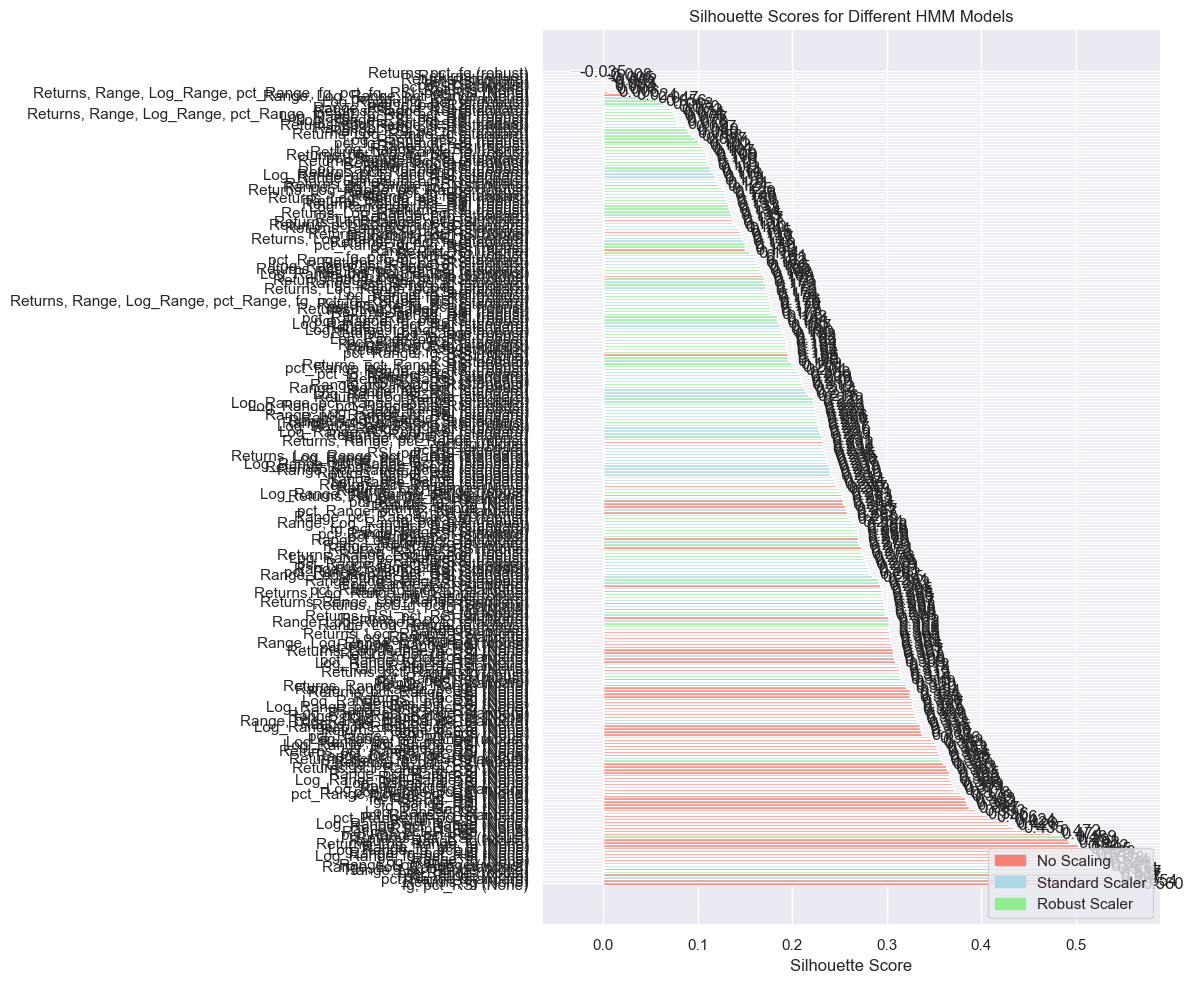

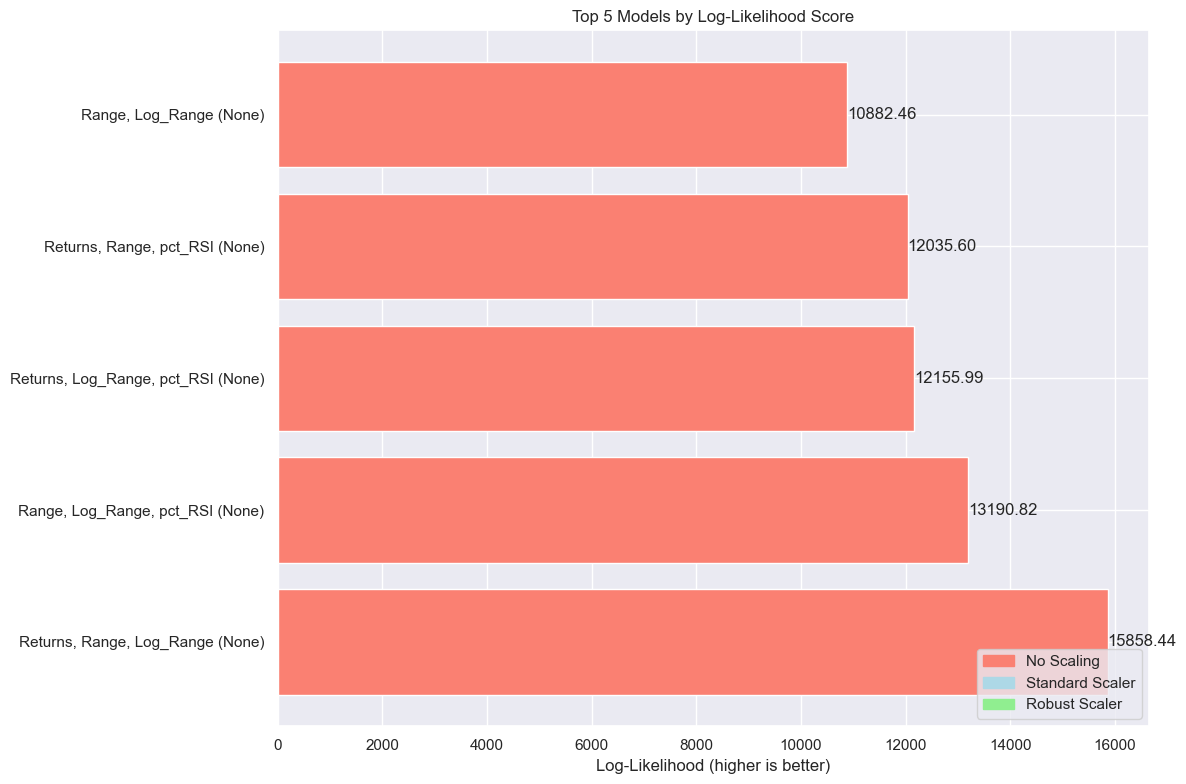

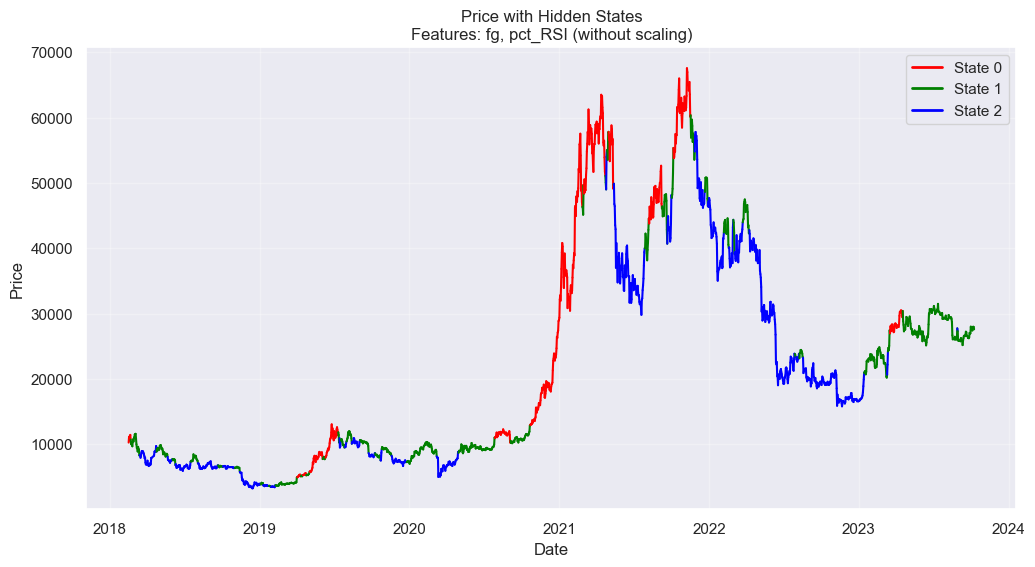

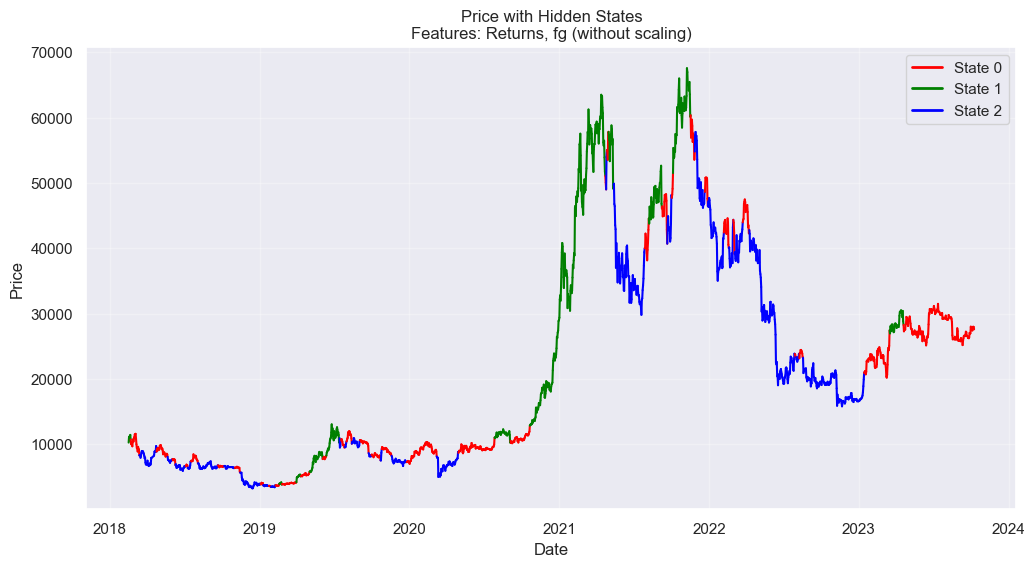

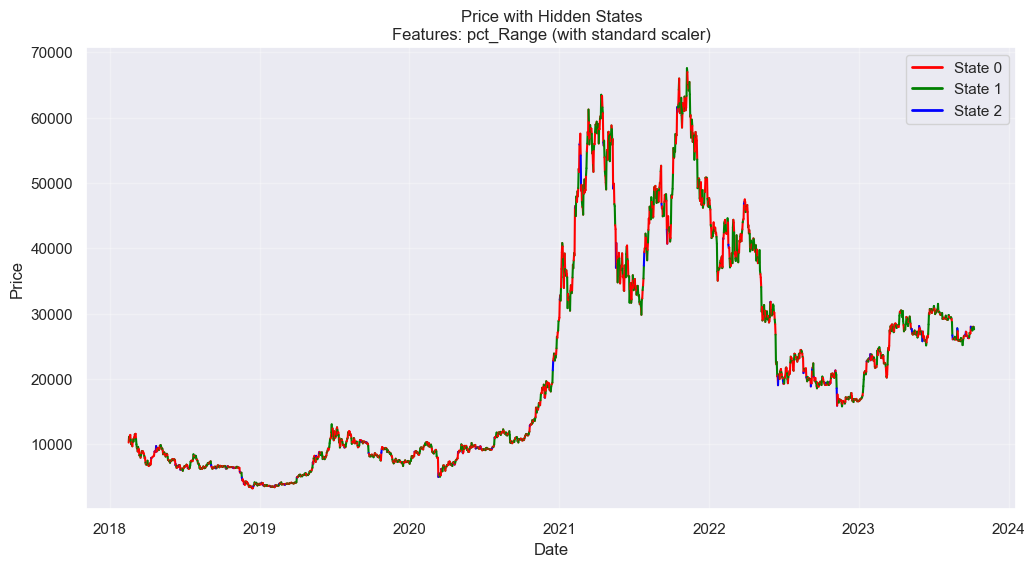

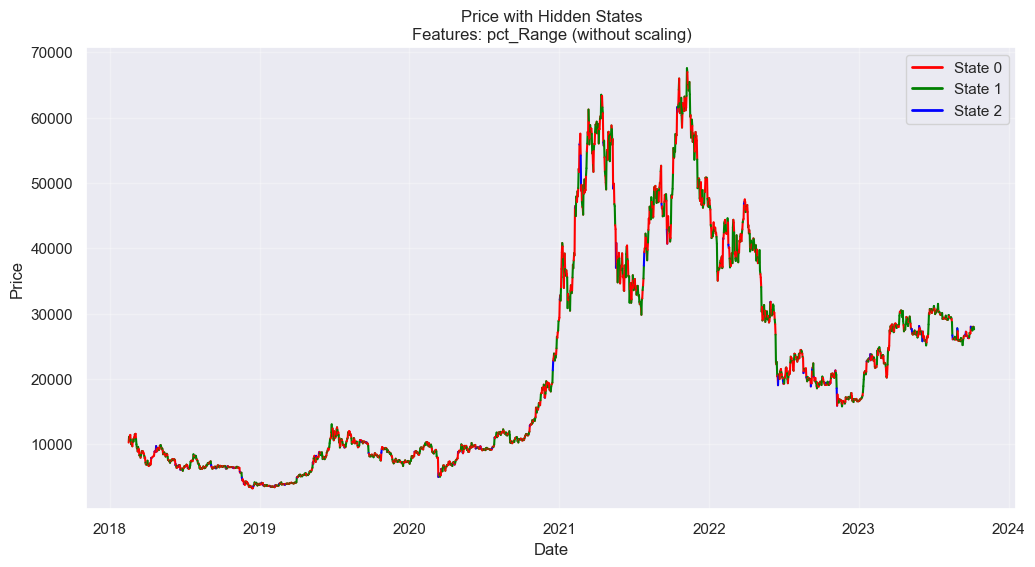

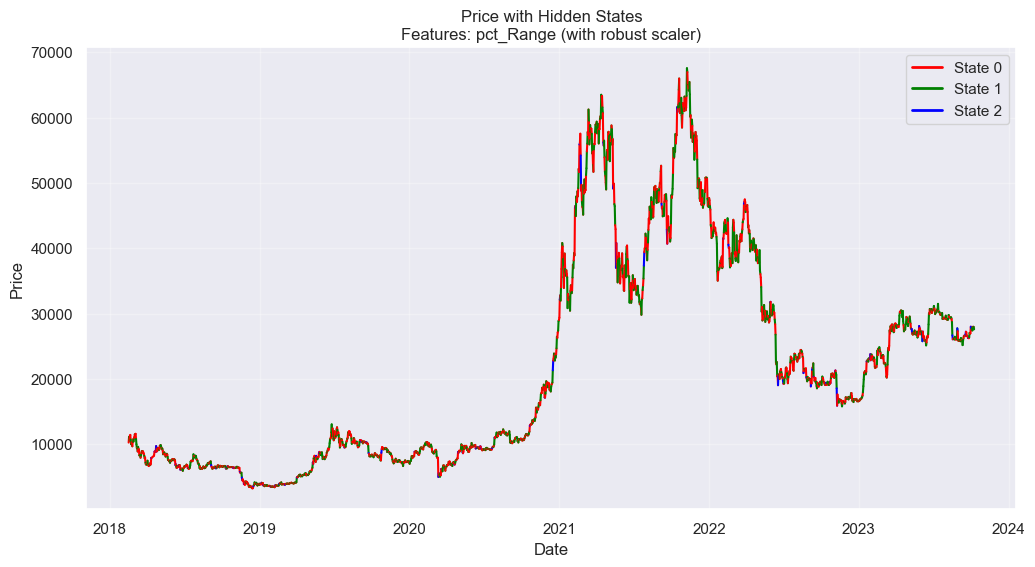

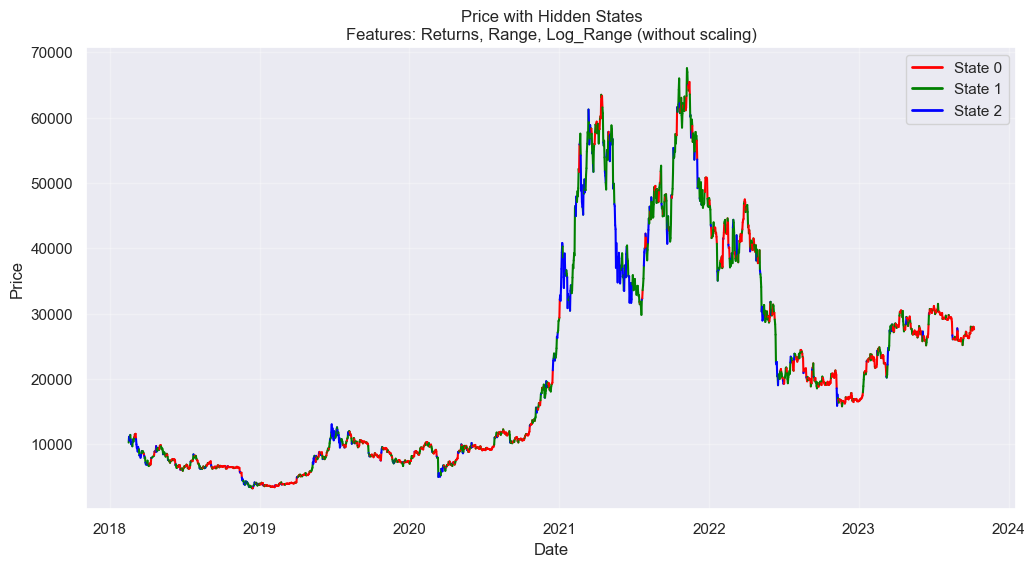

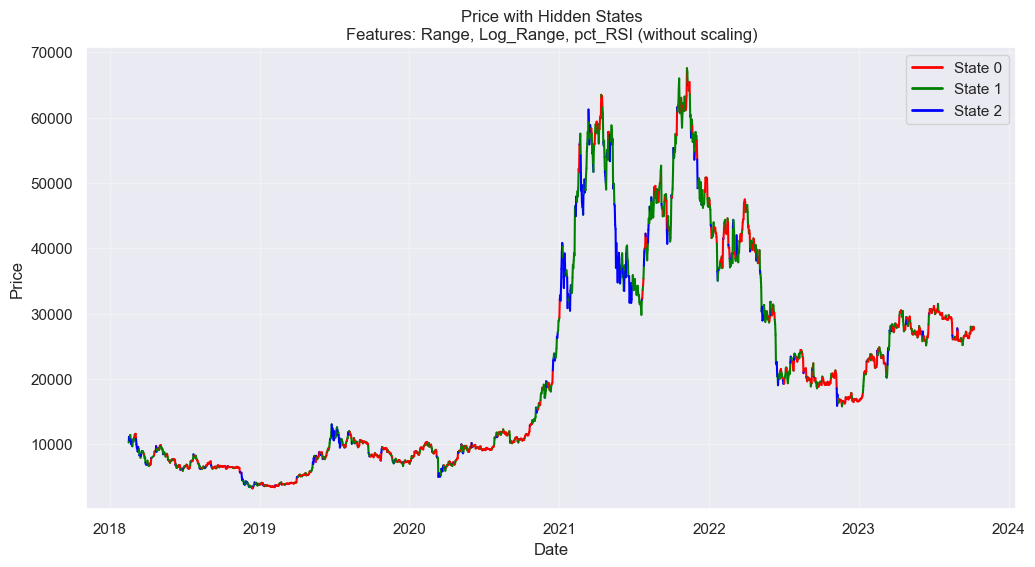

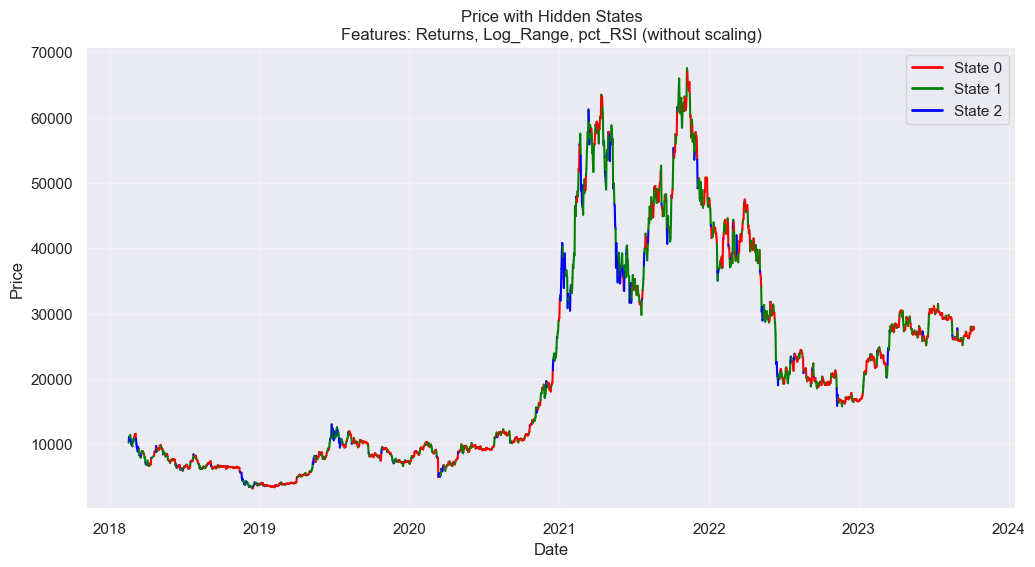

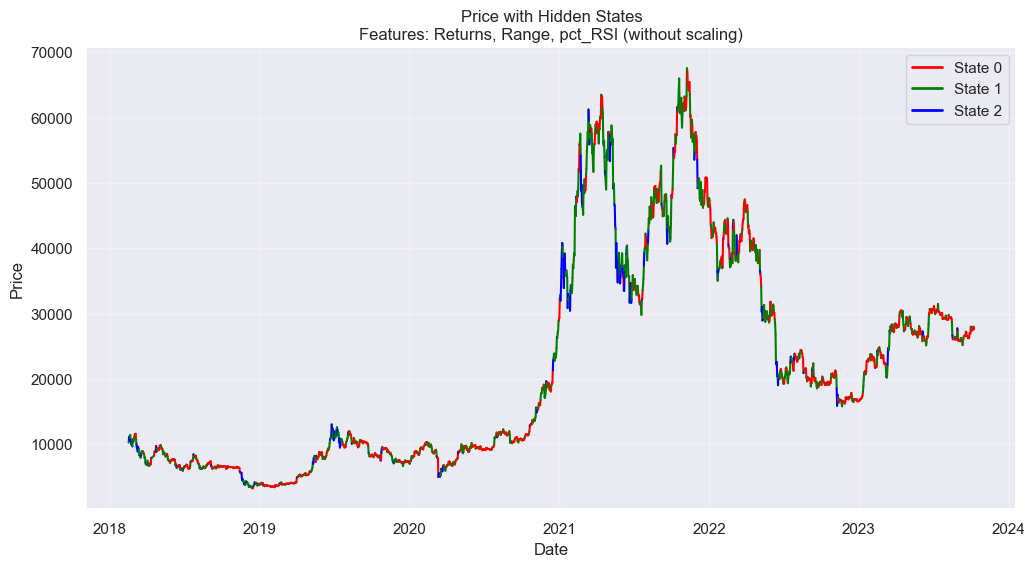

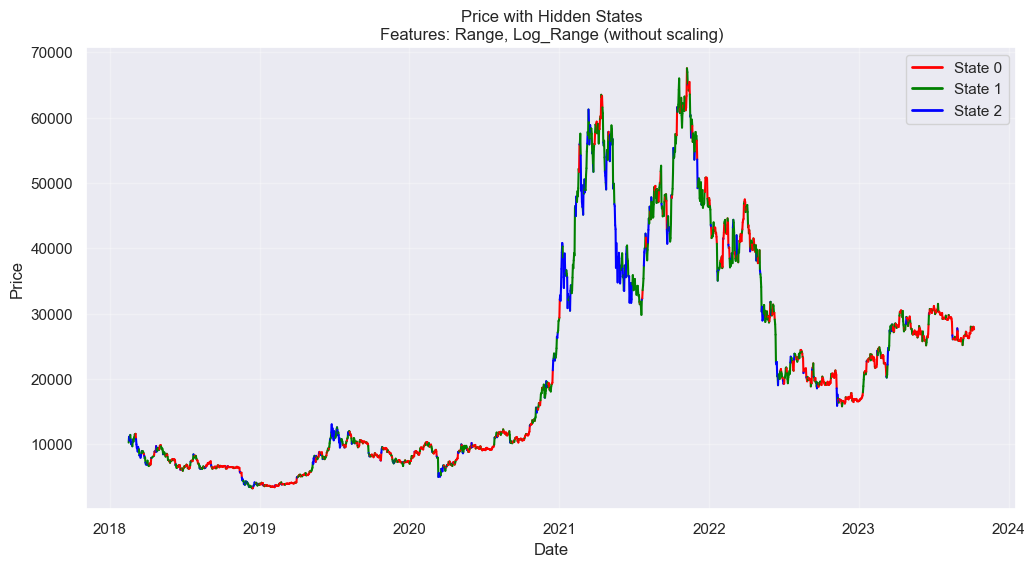

In [12]:
# Run the complete comparison analysis
results = run_hmm_comparison(df, col_list, n_states=3)

# Show all figures
plt.show()

In [13]:
def create_specific_feature_plots(df, n_states=3):
    """
    Create specific plots for pct_RSI, pct_fg, and fg without changing existing functions
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing the features and price data
    n_states : int
        Number of hidden states for the HMM
    
    Returns:
    --------
    dict
        Dictionary containing the specific feature plots
    """
    # Create individual plots for each specific feature
    feature_plots = {}
    
    # 1. Plot for pct_RSI
    print("Generating plot for pct_RSI...")
    pct_rsi_result = train_evaluate_hmm(df, ['pct_RSI'], n_states=n_states, scaler_type='standard')
    if pct_rsi_result:
        pct_rsi_fig = plot_price_with_states(pct_rsi_result)
        feature_plots['pct_RSI'] = pct_rsi_fig
        print(f"- pct_RSI (standard scaling): Log-Likelihood = {pct_rsi_result['log_likelihood']:.4f}, " 
              f"Silhouette = {pct_rsi_result['silhouette_score']:.4f}")
    
    # 2. Plot for pct_fg
    print("Generating plot for pct_fg...")
    pct_fg_result = train_evaluate_hmm(df, ['pct_fg'], n_states=n_states, scaler_type='standard')
    if pct_fg_result:
        pct_fg_fig = plot_price_with_states(pct_fg_result)
        feature_plots['pct_fg'] = pct_fg_fig
        print(f"- pct_fg (standard scaling): Log-Likelihood = {pct_fg_result['log_likelihood']:.4f}, "
              f"Silhouette = {pct_fg_result['silhouette_score']:.4f}")
    
    # 3. Plot for fg
    print("Generating plot for fg...")
    fg_result = train_evaluate_hmm(df, ['fg'], n_states=n_states, scaler_type='standard')
    if fg_result:
        fg_fig = plot_price_with_states(fg_result)
        feature_plots['fg'] = fg_fig
        print(f"- fg (standard scaling): Log-Likelihood = {fg_result['log_likelihood']:.4f}, "
              f"Silhouette = {fg_result['silhouette_score']:.4f}")
    
    return feature_plots

Generating plot for pct_RSI...
- pct_RSI (standard scaling): Log-Likelihood = -2576.7736, Silhouette = 0.0020
Generating plot for pct_fg...
- pct_fg (standard scaling): Log-Likelihood = -1954.7073, Silhouette = 0.2323
Generating plot for fg...
- fg (standard scaling): Log-Likelihood = -1822.1803, Silhouette = 0.2980


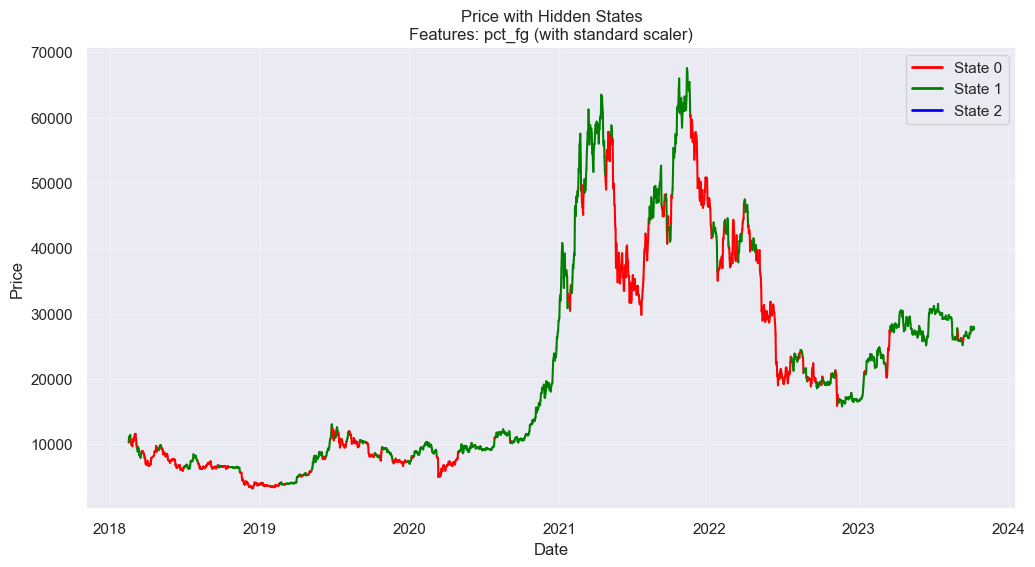

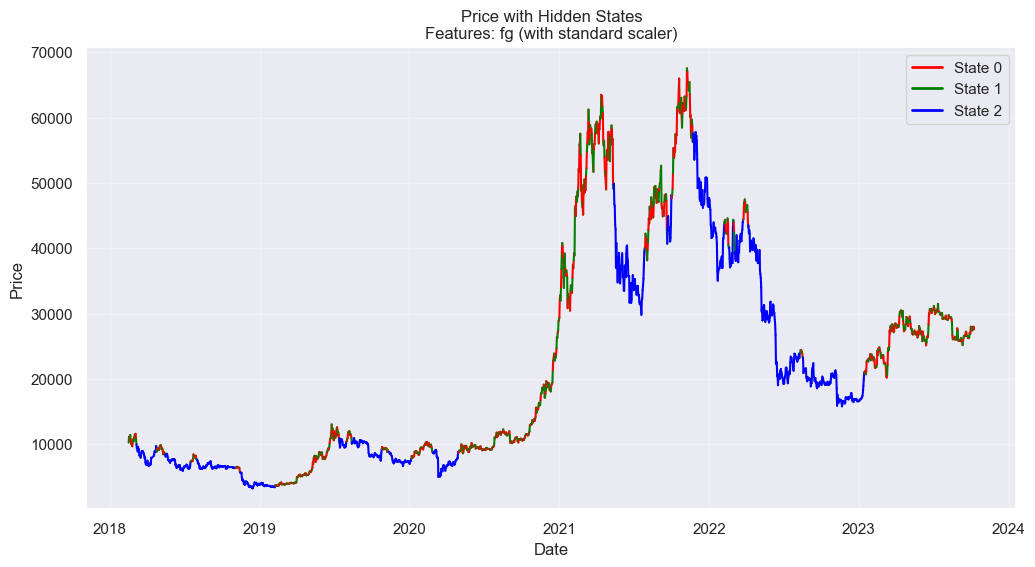

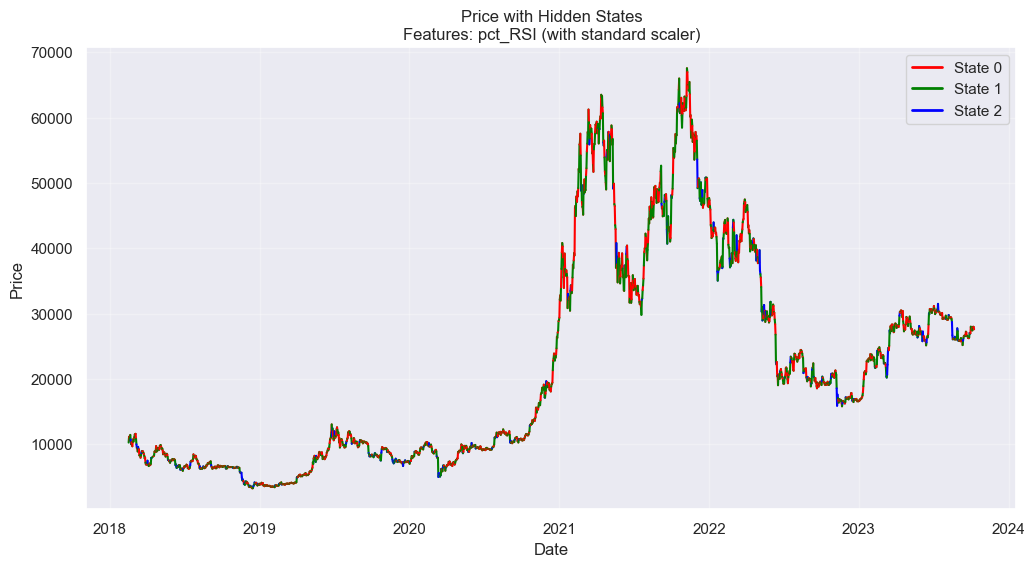

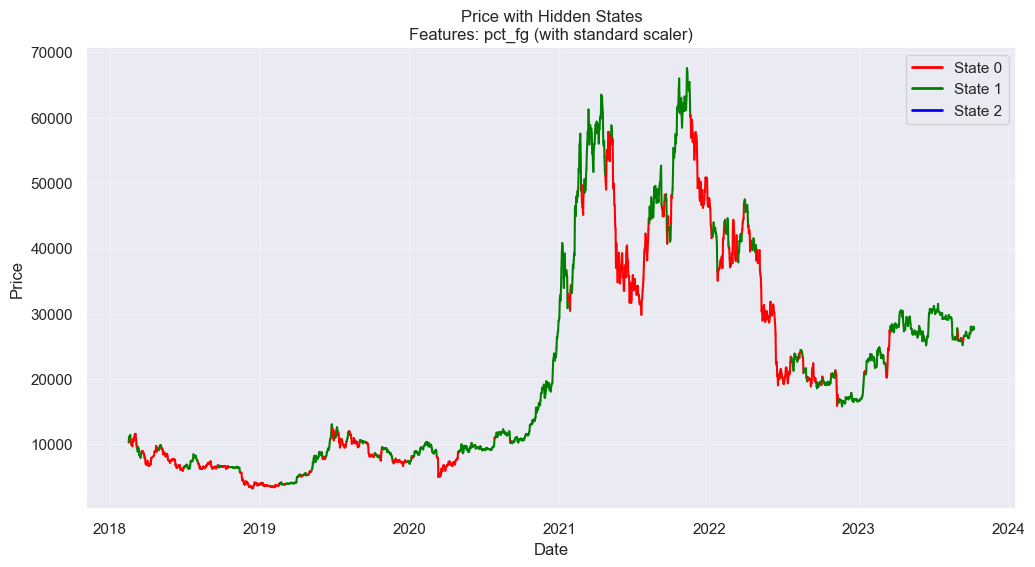

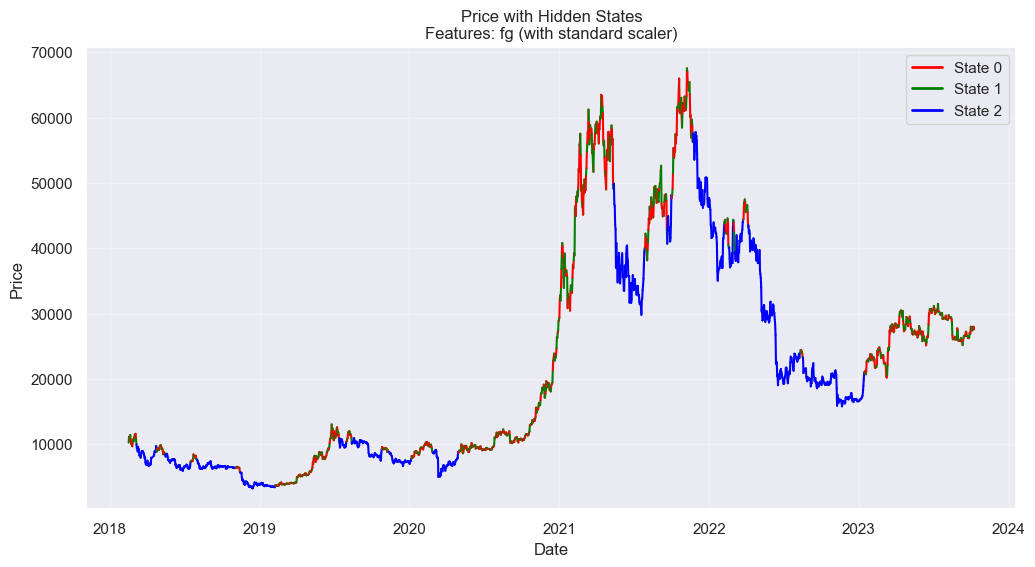

In [14]:
feature_plots = create_specific_feature_plots(df)

# You can then display or save each plot
plt.figure(feature_plots['pct_RSI'])
plt.show()

plt.figure(feature_plots['pct_fg']) 
plt.show()

plt.figure(feature_plots['fg'])
plt.show()